In [60]:
from typing import TypedDict, Annotated, List, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from IPython.display import Image, display

from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, MessagesPlaceholder, PromptTemplate, BasePromptTemplate
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema import PromptValue
from langchain.agents import AgentExecutor
from langchain.agents import create_tool_calling_agent
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langsmith import traceable

from dotenv import load_dotenv
import os

from langchain_google_genai import ChatGoogleGenerativeAI

In [2]:
load_dotenv()

# Set environment variables
langsmith_api_key = os.getenv("LANGSMITH_API_KEY")

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = langsmith_api_key

In [3]:
# Initialize LLM
api_key = os.getenv("GOOGLE_API_KEY")

# Set it as an environment variable (LangChain uses this)
os.environ["GOOGLE_API_KEY"] = api_key

llm_gemini = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

## Testing 
-> Using LLM but no Reasoning, just pass user query in and receiving result by gemini

In [ ]:
# Using LLM but no Reasoning, just pass in and receiving result
class State(TypedDict):
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


# This is a built-in state schema provided by LangGraph
# class MessagesState(TypedDict):    
#     messages: Annotated[List[BaseMessage], add_messages]

# graph_builder = StateGraph(MessagesState) 


def chatbot(state: State):
    return {"messages": [llm_gemini.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

In [8]:
# Initial message from the user
initial_state = {
    "messages": [HumanMessage(content="Tell me a joke about AI.")]
}

# Run the graph
output = graph.invoke(initial_state)

# Print the assistant's reply
assistant_message = output["messages"][-1]
print("Assistant:", assistant_message.content)


Assistant: Why did the AI cross the road?

To prove to the chicken that it wasn't just a simulation.


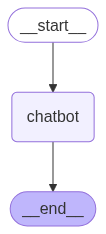

In [ ]:
graph

## Testing 2
-> Using LLM to Reasoning about which tool they should use (The tool is functions, not agents)

In [5]:
# Define the state for the LangGraph
class QAState(TypedDict):
    messages: Annotated[List, "Chat history"]       # The second attribute is a metadata
    question_type: Annotated[Literal["search", "math", "direct"], "Type of the question"]
    result: Annotated[str, "Final result or answer"]

In [6]:
# Classifier node: classify question type
@traceable(name="classify_question")
def classify_question(state: QAState) -> dict:
    last_question = state["messages"][-1].content  # Take the last message content to inform this node of the context
    prompt = f"""
    Classify the following question into one of these types:
    - 'search' if it needs real-time or external info (like today's news or prices)
    - 'math' if it's a calculation
    - 'direct' if it's factual and can be answered directly from memory
    
    Question: "{last_question}"
    
    Only respond with one word: search, math, or direct.
    """

    response = llm_gemini.invoke([HumanMessage(content=prompt)])
    question_type = response.content.strip().lower()

    return {"question_type": question_type}


In [ ]:
# 1. Search tool
@traceable
def search_tool(state: QAState) -> dict:
    question = state["messages"][-1].content
    # Simulate search result
    result = f"(search result for: '{question}') → Example: 'Tesla's stock is $123.45'"
    return {"result": result}

# 2. Math calculator tool
@traceable
def calculator_tool(state: QAState) -> dict:
    question = state["messages"][-1].content
    try:
        result = str(eval(question))
    except:
        result = "Math error or unsafe input."
    return {
        "messages": state["messages"], # pass forward
        "result": result
    }

# 3. Direct answering using the LLM
@traceable
def direct_answer(state: QAState) -> dict:
    messages = state["messages"]
    response = llm_gemini.invoke(messages)
    return {"result": response.content}

# 4. Final answer generator (used after tool-based info)
@traceable
def generate_answer(state: QAState) -> dict:
    messages = state["messages"] + [AIMessage(content=state["result"])]
    response = llm_gemini.invoke(messages)
    return {"result": response.content}

In [11]:
# Set up the LangGraph
builder = StateGraph(QAState)

# Add nodes
builder.add_node("classify", classify_question)
builder.add_node("search", search_tool)
builder.add_node("math", calculator_tool)
builder.add_node("direct", direct_answer)
builder.add_node("generate", generate_answer)

# Define routes
builder.set_entry_point("classify")

builder.add_conditional_edges(
    "classify",
    lambda state: state["question_type"],
    {
        "search": "search",
        "math": "math",
        "direct": "direct"
    }
)

# Route to final generator if tool was used
builder.add_edge("search", "generate")
builder.add_edge("math", "generate")

# End if direct answer
builder.add_edge("direct", END)
builder.add_edge("generate", END)

# Compile the graph
graph = builder.compile()

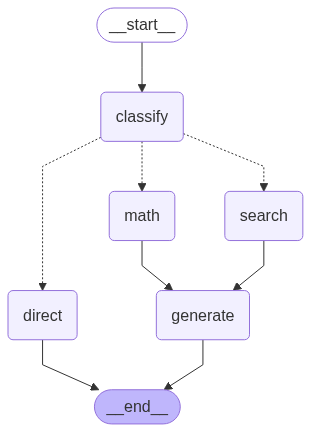

In [90]:
graph

In [ ]:
# Example question
question = "What is the capital of Viet Nam?"

state = {
    "messages": [HumanMessage(content=question)],
    "question_type": "direct",  # Initial dummy value
    "result": "",
}

# # Run the graph
# final_state = graph.invoke(state)

# print("Final Answer:", final_state["result"])

stream = graph.stream(state)
for output in stream:
    print(output)


{'classify': {'question_type': 'direct'}}
{'direct': {'result': 'The capital of Vietnam is **Hanoi**.'}}


In [106]:
final_state

{'messages': [HumanMessage(content='what is 1+1', additional_kwargs={}, response_metadata={})],
 'question_type': 'math',
 'result': ''}

## Test 3
-> Simple LangGraph using 3 math tools to understand the flow of LangGraph (No Agents involve)

In [ ]:
# Define your state
class State(TypedDict):
    expression: str                # e.g. "5 + 3", "10 / 2", "7 - 4"
    tool: Literal["add", "subtract", "divide", ""]  # tool chosen by decision node, "" when unset
    result: float                 # computation result

# Math nodes
def add_node(state: State) -> dict:
    a, b = map(float, state["expression"].split("+"))
    return {"result": a + b}

def subtract_node(state: State) -> dict:
    a, b = map(float, state["expression"].split("-"))
    return {"result": a - b}

def divide_node(state: State) -> dict:
    a, b = map(float, state["expression"].split("/"))
    return {"result": a / b if b != 0 else float("inf")}

# Decision node returning dict to update 'tool' in state
def decide_tool_node(state: State) -> dict:
    expr = state["expression"]
    if "+" in expr:
        return {"tool": "add"}
    elif "-" in expr:
        return {"tool": "subtract"}
    elif "/" in expr:
        return {"tool": "divide"}
    else:
        raise ValueError(f"Unsupported expression: {expr}")

# Conditional edge function returning next node name string from state
def get_next_node(state: State) -> str:
    return state["tool"]

# Build the graph
builder = StateGraph(State)
builder.add_node("decide_tool", decide_tool_node)
builder.add_node("add", add_node)
builder.add_node("subtract", subtract_node)
builder.add_node("divide", divide_node)

builder.add_edge(START, "decide_tool")

builder.add_conditional_edges("decide_tool", get_next_node, {
    "add": "add",
    "subtract": "subtract",
    "divide": "divide",
})

builder.add_edge("add", END)
builder.add_edge("subtract", END)
builder.add_edge("divide", END)

graph = builder.compile()

# Test cases
test_expressions = ["5 + 7", "10 - 3", "20 / 4"]




for expr in test_expressions:
    initial_state = {"expression": expr, "tool": "", "result": 0.0}
    final_state = graph.invoke(initial_state)
    print(f"Expression: {expr}, Used tool: {final_state['tool']}, Result: {final_state['result']}")


Expression: 5 + 7, Used tool: add, Result: 12.0
Expression: 10 - 3, Used tool: subtract, Result: 7.0
Expression: 20 / 4, Used tool: divide, Result: 5.0


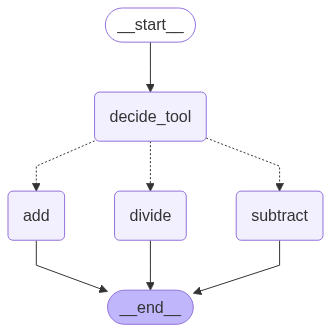

In [30]:
graph

## Test 4
-> Using Agent to decide which tool to use

In [ ]:
date_agent.invoke("What is today date?")

In [70]:
from langchain.tools import tool
import datetime

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant"),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

# 1. State definition
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 2. Define tools
@tool
def add_numbers(a: float, b: float) -> float:
    """Add two numbers"""
    return a + b

@tool
def get_current_day() -> str:
    """Returns the current day of the week"""
    return datetime.datetime.now().strftime("%A")

# https://langchain-ai.github.io/langgraph/agents/agents/#2-create-an-agent
# Agent for math
math_agent = create_tool_calling_agent(llm_gemini, 
                                tools=[add_numbers], 
                                prompt=prompt)


# Agent for date/time
date_agent = create_tool_calling_agent(llm_gemini,
                            tools=[get_current_day],
                            prompt=prompt)


def math_node(state: State) -> State:
    messages = state["messages"]
    result = math_agent.invoke({"input": messages[-1].content})
    return {"messages": [HumanMessage(content=result["output"])]}


def date_node(state: State) -> State:
    messages = state["messages"]
    result = date_agent.invoke({"input": messages[-1].content})
    return {"messages": [HumanMessage(content=result["output"])]}

# 5. Create the graph
builder = StateGraph(State)
builder.add_node("math", math_node)
builder.add_node("date", date_node)

# Simple router — in real case use classifier or logic
def router(state: State) -> str:
    last_msg = state["messages"][-1].content.lower()
    if "add" in last_msg or "sum" in last_msg:
        return "math"
    elif "day" in last_msg or "today" in last_msg:
        return "date"
    else:
        return "date"  # default


builder.add_node("router", router)
builder.set_entry_point("router")
builder.add_conditional_edges("router", router, {
    "math": "math",
    "date": "date"
})
builder.add_edge("math", END)
builder.add_edge("date", END)

graph = builder.compile()

# 6. Run

user_input = "What is 1+1"

inputs = {"messages": [HumanMessage(content=user_input)]}
final_state = graph.invoke(inputs)

# print("\nAgent response:\n")
# for msg in final_state["messages"]:
#     print(msg.content)


InvalidUpdateError: Expected dict, got date
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE

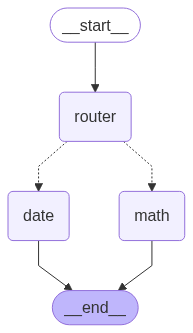

In [26]:
graph

### Prompt

In [ ]:
# This use for create_tool_calling_agent
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant"),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)
prompt

In [78]:
# Making Prompt for AgentExecutor

# Define the system message prompt
system_prompt = SystemMessagePromptTemplate(
    prompt=PromptTemplate(
        input_variables=[],
        template="You are an assisstant to help user know what the current day of the week is "
    )
)

# Define the human message prompt
human_prompt = HumanMessagePromptTemplate(
    prompt=PromptTemplate(
        input_variables=["input"],
        template="{input}"
    )
)

# Combine prompts with chat history and agent scratchpad
prompt = [
    system_prompt,
    MessagesPlaceholder(variable_name="chat_history", optional=True),
    human_prompt,
    MessagesPlaceholder(variable_name="agent_scratchpad")
]

print(prompt)
# ---------------------------------------------------------------------------------------------------------------------
from langchain import hub
prompt = hub.pull("hwchase17/openai-functions-agent")
prompt.messages

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are an assisstant to help user know what the current day of the week is '), additional_kwargs={}), MessagesPlaceholder(variable_name='chat_history', optional=True), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='{input}'), additional_kwargs={}), MessagesPlaceholder(variable_name='agent_scratchpad')]


[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a helpful assistant'), additional_kwargs={}),
 MessagesPlaceholder(variable_name='chat_history', optional=True),
 HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='{input}'), additional_kwargs={}),
 MessagesPlaceholder(variable_name='agent_scratchpad')]

In [80]:
# LangGraph with only date_agent
# 1. State definition
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 2. Tool
@tool
def get_current_day() -> str:
    """Returns the current day of the week"""
    return datetime.datetime.now().strftime("%A")


date_agent = create_tool_calling_agent(
    llm_gemini,
    tools=[get_current_day],
    prompt=prompt
)

date_agent_executor = AgentExecutor(
    agent=date_agent,
    tools=[get_current_day],
    verbose=True
)

# 5. Define the node
def date_node(state: State) -> State:
    user_message = state["messages"][-1].content
    result = date_agent_executor.invoke({"input": user_message})
    return {"messages": [HumanMessage(content=result["output"])]}

# 6. Build the graph
builder = StateGraph(State)
builder.add_node("date", date_node)
builder.set_entry_point("date")
builder.add_edge("date", "__end__")

graph = builder.compile()

# 7. Run it
user_input = "What is the current day of the week?"
inputs = {"messages": [HumanMessage(content=user_input)]}
final_state = graph.invoke(inputs)

print("\nAnswer:\n")
for msg in final_state["messages"]:
    print(msg.content)




> Entering new AgentExecutor chain...

Invoking: `get_current_day` with `{}`


FridayToday is Friday.


> Finished chain.

Answer:

What is the current day of the week?
Today is Friday.



In [ ]:
from langgraph.prebuilt import create_react_agent

@tool   # Using AgentExecutor only
def get_current_day() -> str:
    """Returns the current day of the week"""
    return datetime.datetime.now().strftime("%A")

date_agent = create_tool_calling_agent(  
    llm_gemini,
    tools=[get_current_day],
    prompt=prompt
)

date_agent_executor = AgentExecutor(
    agent=date_agent,
    tools=[get_current_day],
    verbose=True
)

response = date_agent_executor.invoke({"input": "What is the current day of the week?"})
print(response["output"])




> Entering new AgentExecutor chain...


KeyError: "Input to ChatPromptTemplate is missing variables {'agent_scratchpad', 'input'}.  Expected: ['agent_scratchpad', 'input'] Received: ['messages', 'is_last_step', 'remaining_steps']\nNote: if you intended {agent_scratchpad} to be part of the string and not a variable, please escape it with double curly braces like: '{{agent_scratchpad}}'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT "

## Test 5
-> Testing Online Code

In [5]:
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, justification="Why this query is relevant to the user's request."
    )

# Augment the LLM with schema for structured output
structured_llm = llm_gemini.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output.search_query)
print(output.justification)

Calcium CT score and high cholesterol
To find the relationship between Calcium CT score and high cholesterol.


In [6]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm_gemini.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2.0, 'b': 3.0},
  'id': 'dd85e3ff-74bc-400d-84e9-eebc0552d28b',
  'type': 'tool_call'}]